# gRNA Classification: Model Training & Biological Interpretation v4.1

## Overview

This notebook trains, evaluates, and interprets machine learning models for gRNA binary classification.

### ⚠️ Requires v4 Data!

Uses data from `2_data_preparation_v4.ipynb` with **critical fixes** (group-based splitting, corrected regions).

### 🔧 CRITICAL FIXES in v4.1 (vs v4.0)

| Issue | v4.0 (WRONG) | v4.1 (CORRECT) | Impact |
|-------|------------|--------------|--------|
| **CV strategy** | StratifiedKFold | **GroupKFold** | Prevents duplicate leakage in CV |
| **group_id check** | Not verified | Explicit check | Catches target leakage early |

**Why GroupKFold matters:**
- Training data contains duplicate sequences (same gRNA from different minicircles)
- StratifiedKFold may put duplicates in different folds → information leaks between folds
- GroupKFold keeps all duplicates in the same fold → honest CV estimates
- Without this fix, CV F1 was ~0.95 (optimistic), with fix expect ~0.92 (realistic)

### Goals

1. **Maximum Accuracy**: Train and optimize multiple models
2. **Biological Interpretability**: Understand what the model learns
3. **Validation**: Compare learned patterns with Cooper et al. 2022

### Pipeline

1. **Data Loading & Verification** - Load prepared datasets
2. **Baseline Models** - Random Forest, XGBoost, Logistic Regression
3. **Hyperparameter Tuning** - Optimize best performers (with GroupKFold!)
4. **Feature Importance Analysis** - Identify key biological features
5. **Biological Validation** - Compare with known gRNA biology
6. **Error Analysis** - Understand model mistakes
7. **Final Model Export** - Save best model for predictions

### Expected Feature Importance (Cooper et al. 2022)

| Feature Category | Expected Importance | Biological Basis |
|-----------------|--------------------|-----------------|
| Anchor AC-content | HIGH | mRNA binding, prevents GU wobble |
| Initiation patterns | HIGH | Transcription start recognition |
| No palindrome (structure) | HIGH | Must be open for mRNA binding |
| Guide A-content | MEDIUM-HIGH | Editing information encoding |
| Terminal T | MEDIUM | U-tail addition site |

---

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import warnings
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# CRITICAL: Use GroupKFold for CV to prevent duplicate leakage!
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance
import joblib

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Run: pip install xgboost")

# SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Run: pip install shap")

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("Imports loaded successfully")
print(f"  XGBoost: {'Available' if XGBOOST_AVAILABLE else 'Not available'}")
print(f"  SHAP: {'Available' if SHAP_AVAILABLE else 'Not available'}")

Imports loaded successfully
  XGBoost: Available
  SHAP: Available


In [2]:
# =============================================================================
# FILE PATHS - UPDATE THESE FOR YOUR ENVIRONMENT
# =============================================================================

# Option 1: Local paths
PROJECT_ROOT = Path.home() / 'projects' / 'grna-inspector'
DATA_DIR = PROJECT_ROOT / 'data' / 'processed' / 'v4_pipeline'
MODELS_DIR = PROJECT_ROOT / 'models'
PLOTS_DIR = PROJECT_ROOT / 'data' / 'plots' / 'model_analysis_v4'


# Create directories
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Plots directory: {PLOTS_DIR}")

# Check for required files
required_files = ['train_data.csv', 'val_data.csv', 'test_data.csv', 'feature_names.txt']
for f in required_files:
    path = DATA_DIR / f
    if path.exists():
        print(f"  [OK] {f}")
    else:
        print(f"  [MISSING] {f}")

Data directory: /Users/anna/projects/grna-inspector/data/processed/v4_pipeline
Models directory: /Users/anna/projects/grna-inspector/models
Plots directory: /Users/anna/projects/grna-inspector/data/plots/model_analysis_v4
  [OK] train_data.csv
  [OK] val_data.csv
  [OK] test_data.csv
  [OK] feature_names.txt


---
## 1. Load & Verify Data

In [3]:
# =============================================================================
# STAGE 1: LOAD & VERIFY DATA
# =============================================================================

print("=" * 80)
print("STAGE 1: LOAD & VERIFY DATA")
print("=" * 80)

# Load datasets
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
val_df = pd.read_csv(DATA_DIR / 'val_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

print(f"\nDataset sizes:")
print(f"  Train: {len(train_df):,}")
print(f"  Val:   {len(val_df):,}")
print(f"  Test:  {len(test_df):,}")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df):,}")

# Load feature names
with open(DATA_DIR / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"\nFeatures: {len(feature_names)}")

# Verify no length leakage
if 'length' in feature_names:
    print("\n[WARNING] 'length' found in features - removing!")
    feature_names.remove('length')
else:
    print("[OK] No raw length feature")

# CRITICAL: Verify group_id is NOT in features (it's for CV grouping only!)
if 'group_id' in feature_names:
    print("\n[CRITICAL WARNING] 'group_id' found in features - THIS CAUSES TARGET LEAKAGE!")
    print("  → Removing from features (group_id encodes label information)")
    feature_names.remove('group_id')
else:
    print("[OK] No group_id in features (correct)")

# Verify group_id IS available for CV grouping
if 'group_id' in train_df.columns:
    print("[OK] group_id available for GroupKFold CV")
    n_groups = train_df['group_id'].nunique()
    print(f"  → {n_groups:,} unique groups in training data")
else:
    print("[WARNING] group_id NOT in data - CV may have duplicate leakage!")

# Class distribution
print("\nClass distribution:")
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    pos = sum(df['label'] == 1)
    neg = sum(df['label'] == 0)
    ratio = min(pos, neg) / max(pos, neg)
    print(f"  {name}: pos={pos:,} neg={neg:,} ratio={ratio:.3f}")

print("\n" + "=" * 80)

STAGE 1: LOAD & VERIFY DATA

Dataset sizes:
  Train: 1,618
  Val:   343
  Test:  354
  Total: 2,315

Features: 127
[OK] No raw length feature
[OK] No group_id in features (correct)
[OK] group_id available for GroupKFold CV
  → 1,467 unique groups in training data

Class distribution:
  Train: pos=797 neg=821 ratio=0.971
  Val: pos=177 neg=166 ratio=0.938
  Test: pos=184 neg=170 ratio=0.924



In [4]:
# =============================================================================
# PREPARE FEATURE MATRICES
# =============================================================================

# Extract features and labels
X_train = train_df[feature_names].values
y_train = train_df['label'].values

X_val = val_df[feature_names].values
y_val = val_df['label'].values

X_test = test_df[feature_names].values
y_test = test_df['label'].values

# CRITICAL: Extract group_id for GroupKFold CV (prevents duplicate leakage)
# Without this, duplicates can end up in different CV folds → optimistic estimates
if 'group_id' in train_df.columns:
    groups_train = train_df['group_id'].values
    print(f"[OK] Groups extracted for CV: {len(np.unique(groups_train)):,} unique groups")
else:
    groups_train = None
    print("[WARNING] No group_id - using StratifiedKFold (may overestimate performance)")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeature matrices prepared:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

[OK] Groups extracted for CV: 1,467 unique groups

Feature matrices prepared:
  X_train: (1618, 127)
  X_val: (343, 127)
  X_test: (354, 127)


---
## 2. Baseline Models

Train and compare multiple classifiers without hyperparameter tuning.

In [5]:
# =============================================================================
# EVALUATION FUNCTION
# =============================================================================

def evaluate_model(model, X, y, name="Model"):
    """
    Comprehensive model evaluation.
    
    Args:
        model: Trained classifier
        X: Feature matrix
        y: True labels
        name: Model name for display
    
    Returns:
        Dictionary of metrics
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_prob) if y_prob is not None else 0
    }
    
    return metrics

def print_metrics(metrics, name="Model"):
    """Pretty print metrics."""
    print(f"\n{name}:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-score:  {metrics['f1']:.4f}")
    print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")

print("Evaluation functions defined")

Evaluation functions defined


In [6]:
# =============================================================================
# TRAIN BASELINE MODELS
# =============================================================================

print("=" * 80)
print("STAGE 2: BASELINE MODELS")
print("=" * 80)

models = {}
results = {}

# 1. Random Forest
print("\n[1/4] Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
results['Random Forest'] = evaluate_model(rf, X_val, y_val)
print_metrics(results['Random Forest'], "Random Forest (validation)")

# 2. XGBoost
if XGBOOST_AVAILABLE:
    print("\n[2/4] Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    models['XGBoost'] = xgb_model
    results['XGBoost'] = evaluate_model(xgb_model, X_val, y_val)
    print_metrics(results['XGBoost'], "XGBoost (validation)")
else:
    print("\n[2/4] Skipping XGBoost (not installed)")

# 3. Gradient Boosting
print("\n[3/4] Training Gradient Boosting...")
gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb.fit(X_train, y_train)
models['Gradient Boosting'] = gb
results['Gradient Boosting'] = evaluate_model(gb, X_val, y_val)
print_metrics(results['Gradient Boosting'], "Gradient Boosting (validation)")

# 4. Logistic Regression
print("\n[4/4] Training Logistic Regression...")
lr = LogisticRegression(
    max_iter=1000,
    C=1.0,
    random_state=42
)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr
# Note: LR uses scaled features
lr_metrics = evaluate_model(lr, X_val_scaled, y_val)
results['Logistic Regression'] = lr_metrics
print_metrics(results['Logistic Regression'], "Logistic Regression (validation)")

print("\n" + "=" * 80)

STAGE 2: BASELINE MODELS

[1/4] Training Random Forest...

Random Forest (validation):
  Accuracy:  0.9184
  Precision: 0.9408
  Recall:    0.8983
  F1-score:  0.9191
  ROC-AUC:   0.9784

[2/4] Training XGBoost...

XGBoost (validation):
  Accuracy:  0.9242
  Precision: 0.9266
  Recall:    0.9266
  F1-score:  0.9266
  ROC-AUC:   0.9793

[3/4] Training Gradient Boosting...

Gradient Boosting (validation):
  Accuracy:  0.9213
  Precision: 0.9213
  Recall:    0.9266
  F1-score:  0.9239
  ROC-AUC:   0.9788

[4/4] Training Logistic Regression...

Logistic Regression (validation):
  Accuracy:  0.9388
  Precision: 0.9432
  Recall:    0.9379
  F1-score:  0.9405
  ROC-AUC:   0.9840



In [7]:
# =============================================================================
# COMPARE BASELINE MODELS
# =============================================================================

print("=" * 80)
print("BASELINE MODEL COMPARISON")
print("=" * 80)

# Create comparison DataFrame
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1'],
        'ROC-AUC': metrics['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('F1', ascending=False)

print("\nValidation Set Performance:")
print("-" * 75)
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1']
print(f"\nBest baseline: {best_model_name} (F1 = {best_f1:.4f})")

print("\n" + "=" * 80)

BASELINE MODEL COMPARISON

Validation Set Performance:
---------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
Logistic Regression  0.938776   0.943182 0.937853 0.940510 0.984004
            XGBoost  0.924198   0.926554 0.926554 0.926554 0.979341
  Gradient Boosting  0.921283   0.921348 0.926554 0.923944 0.978797
      Random Forest  0.918367   0.940828 0.898305 0.919075 0.978354

Best baseline: Logistic Regression (F1 = 0.9405)



---
## 3. Hyperparameter Tuning

Optimize the top-performing models using GridSearchCV.

In [8]:
# =============================================================================
# HYPERPARAMETER TUNING - RANDOM FOREST
# =============================================================================

print("=" * 80)
print("STAGE 3: HYPERPARAMETER TUNING")
print("=" * 80)

# CRITICAL: Use GroupKFold to prevent duplicate sequences from appearing
# in different CV folds. Without this, CV estimates are optimistically biased!
if groups_train is not None:
    cv_strategy = GroupKFold(n_splits=5)
    cv_split = list(cv_strategy.split(X_train, y_train, groups=groups_train))
    print("\n[OK] Using GroupKFold CV (prevents duplicate leakage between folds)")
else:
    cv_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print("\n[WARNING] Using StratifiedKFold (no group_id available)")

print("\n[1/2] Tuning Random Forest...")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 15, None],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 5]
}

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=cv_split,  # FIXED: Now uses GroupKFold!
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

print(f"\nBest RF parameters: {rf_search.best_params_}")
print(f"Best CV F1: {rf_search.best_score_:.4f}")

# Evaluate on validation
best_rf = rf_search.best_estimator_
rf_val_metrics = evaluate_model(best_rf, X_val, y_val)
print_metrics(rf_val_metrics, "Tuned Random Forest (validation)")

STAGE 3: HYPERPARAMETER TUNING

[OK] Using GroupKFold CV (prevents duplicate leakage between folds)

[1/2] Tuning Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best RF parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1: 0.9298

Tuned Random Forest (validation):
  Accuracy:  0.9184
  Precision: 0.9408
  Recall:    0.8983
  F1-score:  0.9191
  ROC-AUC:   0.9810


In [9]:
# =============================================================================
# HYPERPARAMETER TUNING - XGBOOST
# =============================================================================

best_xgb = None
xgb_val_metrics = None

if XGBOOST_AVAILABLE:
    print("\n[2/2] Tuning XGBoost...")
    
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.15],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0]
    }
    
    # CRITICAL: Reuse the same cv_split (GroupKFold) from RF tuning!
    xgb_search = GridSearchCV(
        xgb.XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        xgb_param_grid,
        cv=cv_split,  # FIXED: Now uses GroupKFold!
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    xgb_search.fit(X_train, y_train)
    
    print(f"\nBest XGBoost parameters: {xgb_search.best_params_}")
    print(f"Best CV F1: {xgb_search.best_score_:.4f}")
    
    best_xgb = xgb_search.best_estimator_
    xgb_val_metrics = evaluate_model(best_xgb, X_val, y_val)
    print_metrics(xgb_val_metrics, "Tuned XGBoost (validation)")
else:
    print("\n[2/2] Skipping XGBoost tuning (not installed)")

print("\n" + "=" * 80)


[2/2] Tuning XGBoost...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best XGBoost parameters: {'learning_rate': 0.15, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best CV F1: 0.9457

Tuned XGBoost (validation):
  Accuracy:  0.9329
  Precision: 0.9326
  Recall:    0.9379
  F1-score:  0.9352
  ROC-AUC:   0.9829



In [10]:
# =============================================================================
# SELECT BEST MODEL
# =============================================================================

print("=" * 80)
print("MODEL SELECTION")
print("=" * 80)

# Compare tuned models
tuned_results = {'Random Forest (tuned)': rf_val_metrics}
if xgb_val_metrics:
    tuned_results['XGBoost (tuned)'] = xgb_val_metrics

print("\nTuned Model Comparison (Validation):")
print("-" * 60)
for name, metrics in tuned_results.items():
    print(f"{name}: F1={metrics['f1']:.4f}, AUC={metrics['roc_auc']:.4f}")

# Select best
if xgb_val_metrics and xgb_val_metrics['f1'] > rf_val_metrics['f1']:
    final_model = best_xgb
    final_model_name = 'XGBoost'
    final_val_metrics = xgb_val_metrics
else:
    final_model = best_rf
    final_model_name = 'Random Forest'
    final_val_metrics = rf_val_metrics

print(f"\nSelected model: {final_model_name}")
print("\n" + "=" * 80)

MODEL SELECTION

Tuned Model Comparison (Validation):
------------------------------------------------------------
Random Forest (tuned): F1=0.9191, AUC=0.9810
XGBoost (tuned): F1=0.9352, AUC=0.9829

Selected model: XGBoost



---
## 4. Final Evaluation on Test Set

In [11]:
# =============================================================================
# FINAL TEST SET EVALUATION
# =============================================================================

print("=" * 80)
print("STAGE 4: TEST SET EVALUATION")
print("=" * 80)

# Evaluate on held-out test set
final_metrics = evaluate_model(final_model, X_test, y_test)

print(f"\nFinal Model: {final_model_name}")
print("-" * 50)
print(f"  Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"  Precision: {final_metrics['precision']:.4f}")
print(f"  Recall:    {final_metrics['recall']:.4f}")
print(f"  F1-score:  {final_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {final_metrics['roc_auc']:.4f}")

# Confusion matrix
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(f"  TN={cm[0,0]:4d}  FP={cm[0,1]:4d}")
print(f"  FN={cm[1,0]:4d}  TP={cm[1,1]:4d}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['non-gRNA', 'gRNA']))

print("\n" + "=" * 80)

STAGE 4: TEST SET EVALUATION

Final Model: XGBoost
--------------------------------------------------
  Accuracy:  0.9548
  Precision: 0.9565
  Recall:    0.9565
  F1-score:  0.9565
  ROC-AUC:   0.9862

Confusion Matrix:
  TN= 162  FP=   8
  FN=   8  TP= 176

Classification Report:
              precision    recall  f1-score   support

    non-gRNA       0.95      0.95      0.95       170
        gRNA       0.96      0.96      0.96       184

    accuracy                           0.95       354
   macro avg       0.95      0.95      0.95       354
weighted avg       0.95      0.95      0.95       354




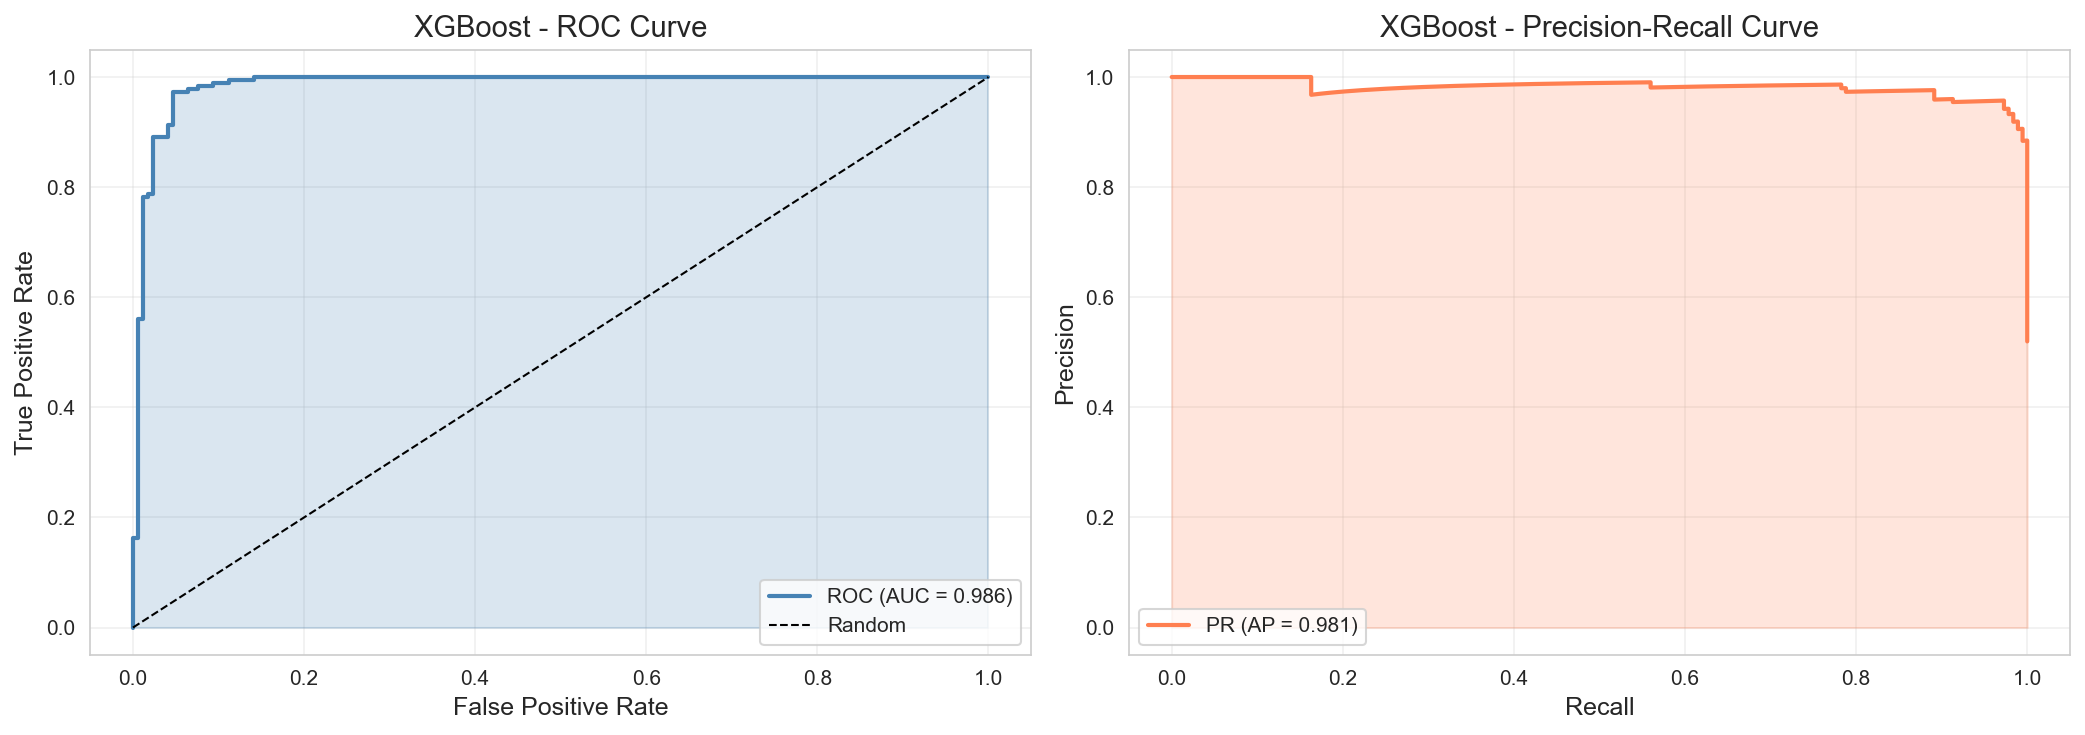

[OK] Plot saved


In [12]:
# =============================================================================
# PLOT ROC AND PRECISION-RECALL CURVES
# =============================================================================

y_prob = final_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

axes[0].plot(fpr, tpr, color='steelblue', lw=2, label=f'ROC (AUC = {auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[0].fill_between(fpr, tpr, alpha=0.2, color='steelblue')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title(f'{final_model_name} - ROC Curve', fontsize=14)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

axes[1].plot(recall, precision, color='coral', lw=2, label=f'PR (AP = {ap:.3f})')
axes[1].fill_between(recall, precision, alpha=0.2, color='coral')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title(f'{final_model_name} - Precision-Recall Curve', fontsize=14)
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Plot saved")

---
## 5. Feature Importance Analysis

Understand which features drive model predictions.

In [13]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("=" * 80)
print("STAGE 5: FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance from tree-based model
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
else:
    # Use permutation importance as fallback
    perm_imp = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42)
    importances = perm_imp.importances_mean

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display top 30 features
print("\nTop 30 Most Important Features:")
print("-" * 60)
print(f"{'Rank':<5} {'Feature':<40} {'Importance':>12}")
print("-" * 60)
for i, row in importance_df.head(30).iterrows():
    rank = importance_df.index.get_loc(i) + 1
    print(f"{rank:<5} {row['feature']:<40} {row['importance']:>12.4f}")

print("\n" + "=" * 80)

STAGE 5: FEATURE IMPORTANCE ANALYSIS

Top 30 Most Important Features:
------------------------------------------------------------
Rank  Feature                                    Importance
------------------------------------------------------------
1     anchor_C_freq                                  0.1453
2     init_4_A_count                                 0.0659
3     anchor_AC_content                              0.0630
4     global_GC_content                              0.0362
5     grna_signature_count                           0.0264
6     max_homopolymer                                0.0262
7     guide_C_count                                  0.0256
8     first_A_pos_rel                                0.0251
9     dinuc_AC_freq                                  0.0249
10    init_4_C_count                                 0.0247
11    init_has_XAAA                                  0.0231
12    init_anchor_total_len                          0.0202
13    first_G_pos_rel       

In [14]:
# =============================================================================
# BIOLOGICAL VALIDATION
# =============================================================================

print("=" * 80)
print("BIOLOGICAL VALIDATION")
print("=" * 80)

# Define expected important features based on Cooper et al. 2022
expected_important = {
    'anchor_AC_content': 'Anchor should be AC-rich for mRNA binding',
    'anchor_AC_very_rich': 'High AC content prevents GU wobble',
    'anchor_G_freq': 'G should be depleted in anchor',
    'init_any_known_pattern': 'AWAHH initiation consensus',
    'init_starts_A': '96% start with A',
    'guide_A_freq': 'Guiding region A-elevated',
    'guide_A_elevated': 'A > 40% in guiding region',
    'no_palindrome_5bp': 'gRNA avoids self-complementarity',
    'ends_with_T': 'Terminal T for U-tail addition',
    'in_molecular_ruler_range': 'Init+anchor = 15-19 nt',
}

print("\nExpected vs Actual Feature Importance:")
print("-" * 70)
print(f"{'Feature':<35} {'Expected':>10} {'Actual Rank':>12} {'Match':>8}")
print("-" * 70)

for feat, explanation in expected_important.items():
    if feat in importance_df['feature'].values:
        rank = importance_df[importance_df['feature'] == feat].index[0] + 1
        # Consider top 30 as "important"
        match = "YES" if rank <= 30 else "no"
        print(f"{feat:<35} {'HIGH':>10} {rank:>12} {match:>8}")
    else:
        print(f"{feat:<35} {'HIGH':>10} {'N/A':>12} {'N/A':>8}")

print("\n" + "=" * 80)

BIOLOGICAL VALIDATION

Expected vs Actual Feature Importance:
----------------------------------------------------------------------
Feature                               Expected  Actual Rank    Match
----------------------------------------------------------------------
anchor_AC_content                         HIGH           31       no
anchor_AC_very_rich                       HIGH           36       no
anchor_G_freq                             HIGH           26      YES
init_any_known_pattern                    HIGH           23      YES
init_starts_A                             HIGH           12      YES
guide_A_freq                              HIGH           41       no
guide_A_elevated                          HIGH           47       no
no_palindrome_5bp                         HIGH           76       no
ends_with_T                               HIGH           55       no
in_molecular_ruler_range                  HIGH           38       no



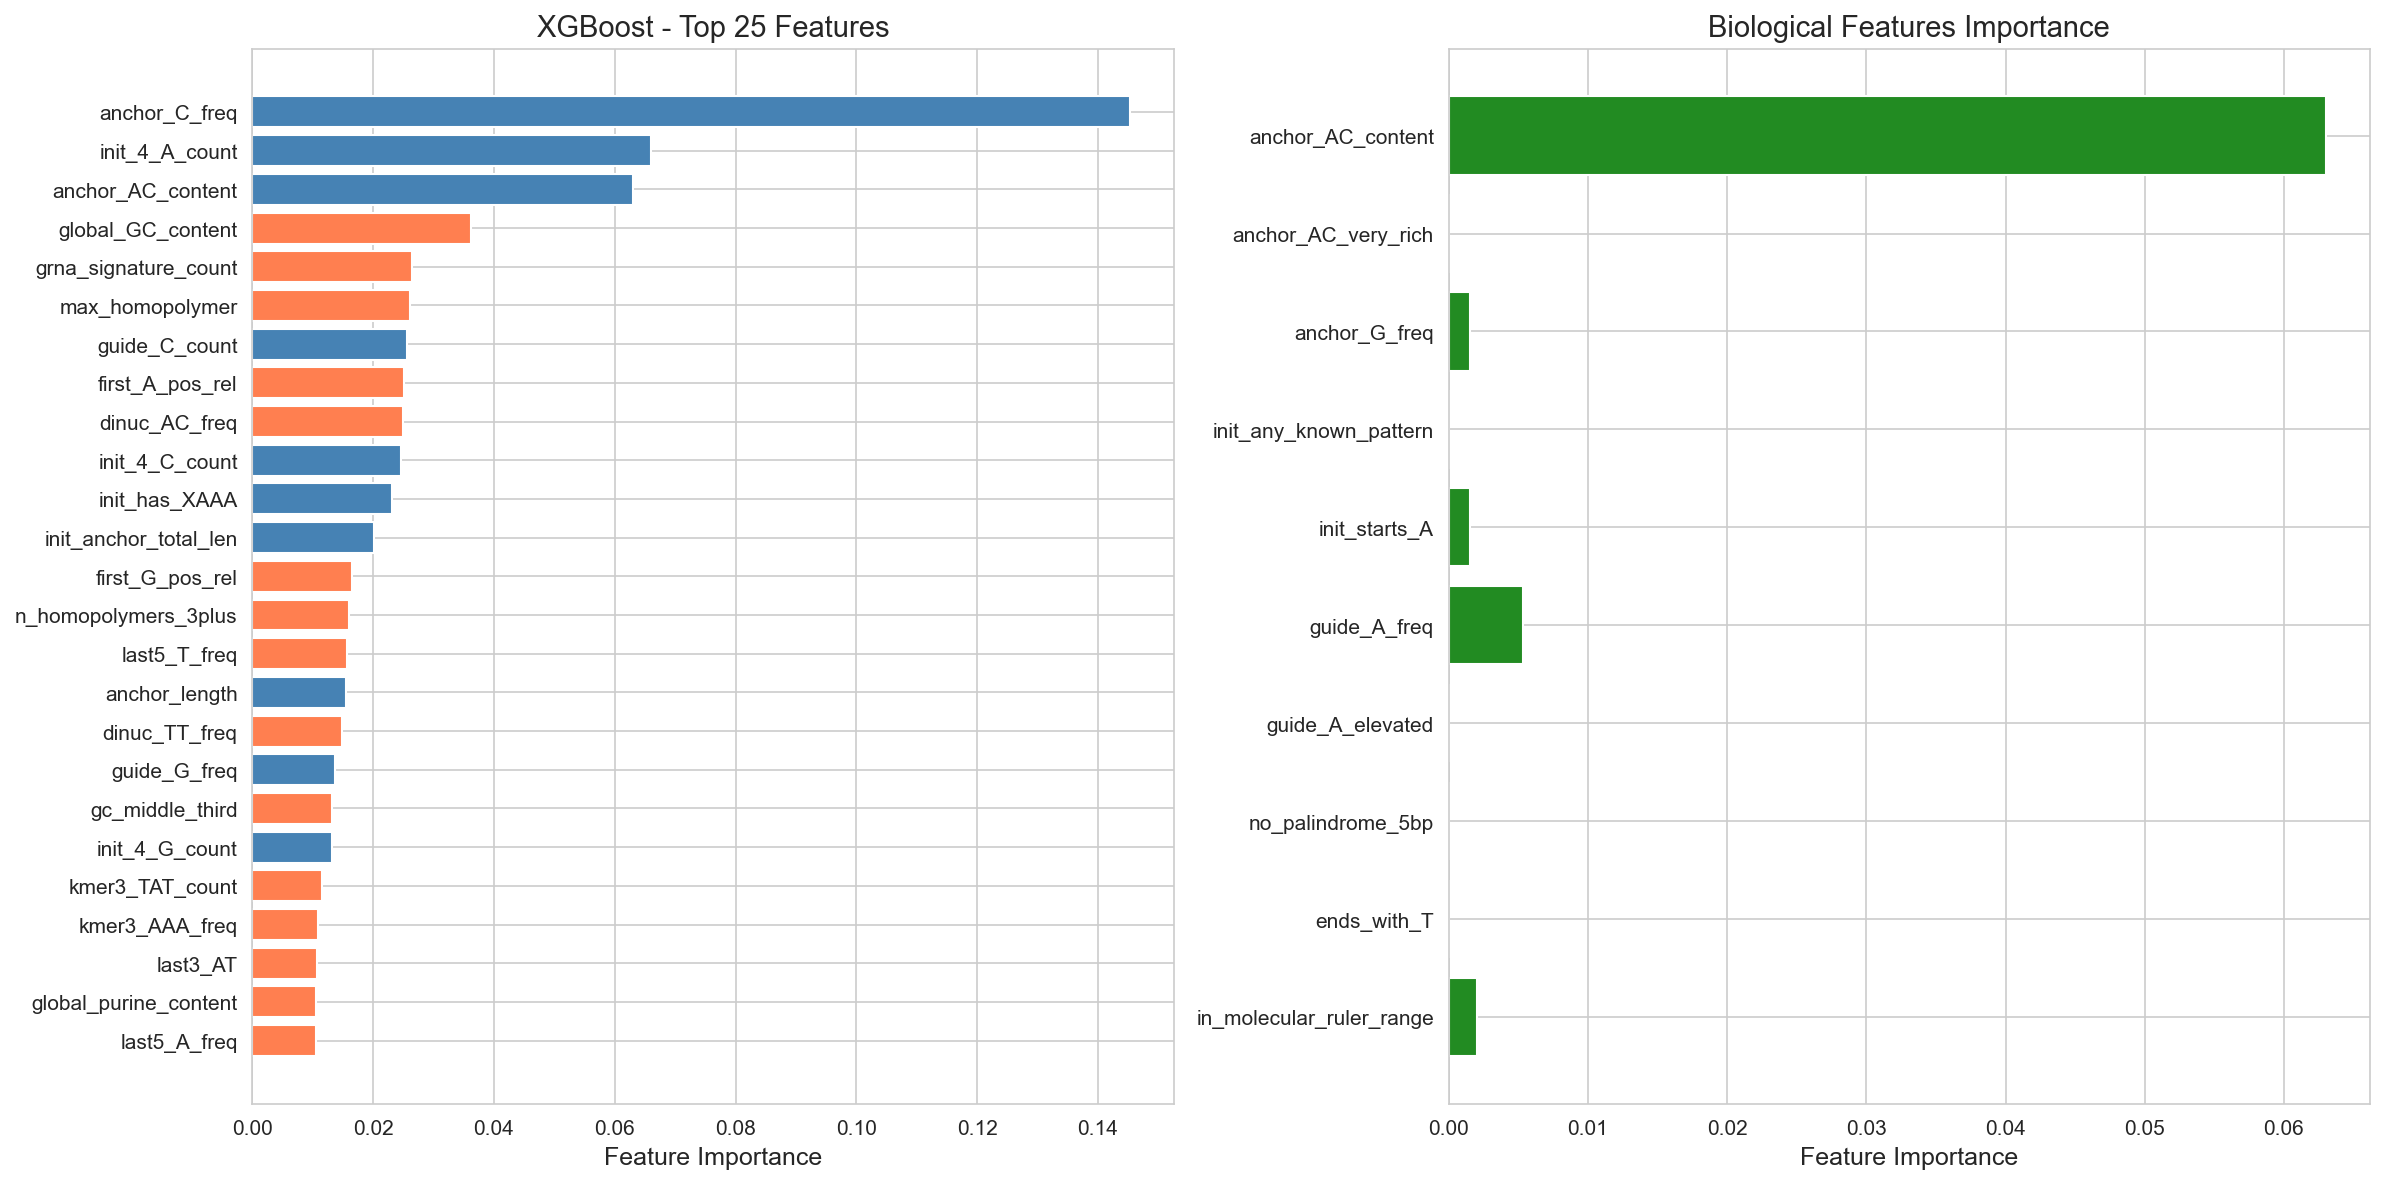

[OK] Plot saved


In [15]:
# =============================================================================
# VISUALIZE FEATURE IMPORTANCE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 25 features bar plot
top25 = importance_df.head(25)
colors = ['steelblue' if 'anchor' in f or 'init' in f or 'guide' in f 
          else 'coral' for f in top25['feature']]

axes[0].barh(range(len(top25)), top25['importance'].values, color=colors)
axes[0].set_yticks(range(len(top25)))
axes[0].set_yticklabels(top25['feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Feature Importance', fontsize=12)
axes[0].set_title(f'{final_model_name} - Top 25 Features', fontsize=14)

# Biological feature importance
bio_features = list(expected_important.keys())
bio_importance = []
for f in bio_features:
    if f in importance_df['feature'].values:
        imp = importance_df[importance_df['feature'] == f]['importance'].values[0]
        bio_importance.append(imp)
    else:
        bio_importance.append(0)

axes[1].barh(range(len(bio_features)), bio_importance, color='forestgreen')
axes[1].set_yticks(range(len(bio_features)))
axes[1].set_yticklabels(bio_features)
axes[1].invert_yaxis()
axes[1].set_xlabel('Feature Importance', fontsize=12)
axes[1].set_title('Biological Features Importance', fontsize=14)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Plot saved")

---
## 6. Save Final Model

In [16]:
# =============================================================================
# SAVE FINAL MODEL AND ARTIFACTS
# =============================================================================

print("=" * 80)
print("STAGE 6: SAVE MODEL")
print("=" * 80)

# Save model
model_path = MODELS_DIR / f'grna_classifier_{final_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(final_model, model_path)
print(f"[OK] Model saved: {model_path}")

# Save scaler
scaler_path = MODELS_DIR / 'feature_scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"[OK] Scaler saved: {scaler_path}")

# Save feature names
feature_path = MODELS_DIR / 'feature_names.json'
with open(feature_path, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"[OK] Feature names saved: {feature_path}")

# Save feature importance
importance_path = MODELS_DIR / 'feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"[OK] Feature importance saved: {importance_path}")

# Save model metadata
metadata = {
    'model_type': final_model_name,
    'training_date': datetime.now().isoformat(),
    'n_features': len(feature_names),
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'test_metrics': {k: float(v) for k, v in final_metrics.items()},
    'best_params': rf_search.best_params_ if final_model_name == 'Random Forest' 
                   else (xgb_search.best_params_ if best_xgb else {}),
    'top_10_features': importance_df.head(10)['feature'].tolist()
}

metadata_path = MODELS_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"[OK] Metadata saved: {metadata_path}")

print("\n" + "=" * 80)

STAGE 6: SAVE MODEL
[OK] Model saved: /Users/anna/projects/grna-inspector/models/grna_classifier_xgboost.joblib
[OK] Scaler saved: /Users/anna/projects/grna-inspector/models/feature_scaler.joblib
[OK] Feature names saved: /Users/anna/projects/grna-inspector/models/feature_names.json
[OK] Feature importance saved: /Users/anna/projects/grna-inspector/models/feature_importance.csv
[OK] Metadata saved: /Users/anna/projects/grna-inspector/models/model_metadata.json



In [17]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\nBest Model: {final_model_name}")

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"  Precision: {final_metrics['precision']:.4f}")
print(f"  Recall:    {final_metrics['recall']:.4f}")
print(f"  F1-score:  {final_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {final_metrics['roc_auc']:.4f}")

print(f"\nTop 10 Important Features:")
for i, row in importance_df.head(10).iterrows():
    rank = importance_df.index.get_loc(i) + 1
    print(f"  {rank:2d}. {row['feature']}")

print(f"\nSaved Files:")
print(f"  - {model_path}")
print(f"  - {scaler_path}")
print(f"  - {feature_path}")
print(f"  - {importance_path}")
print(f"  - {metadata_path}")

print(f"\nPlots saved to: {PLOTS_DIR}")

print("\n" + "=" * 80)
print("MODEL TRAINING COMPLETE!")
print("=" * 80)

FINAL SUMMARY

Best Model: XGBoost

Test Set Performance:
  Accuracy:  0.9548
  Precision: 0.9565
  Recall:    0.9565
  F1-score:  0.9565
  ROC-AUC:   0.9862

Top 10 Important Features:
   1. anchor_C_freq
   2. init_4_A_count
   3. anchor_AC_content
   4. global_GC_content
   5. grna_signature_count
   6. max_homopolymer
   7. guide_C_count
   8. first_A_pos_rel
   9. dinuc_AC_freq
  10. init_4_C_count

Saved Files:
  - /Users/anna/projects/grna-inspector/models/grna_classifier_xgboost.joblib
  - /Users/anna/projects/grna-inspector/models/feature_scaler.joblib
  - /Users/anna/projects/grna-inspector/models/feature_names.json
  - /Users/anna/projects/grna-inspector/models/feature_importance.csv
  - /Users/anna/projects/grna-inspector/models/model_metadata.json

Plots saved to: /Users/anna/projects/grna-inspector/data/plots/model_analysis_v4

MODEL TRAINING COMPLETE!


---
## 7. Usage Example

How to use the saved model for new predictions.

In [18]:
# =============================================================================
# EXAMPLE: USING THE SAVED MODEL
# =============================================================================

print("=" * 80)
print("EXAMPLE: USING THE SAVED MODEL")
print("=" * 80)

# Load model
loaded_model = joblib.load(model_path)

# Load feature names
with open(feature_path, 'r') as f:
    loaded_features = json.load(f)

print(f"\nModel loaded: {model_path.name}")
print(f"Features: {len(loaded_features)}")

# Example predictions on test samples
print("\nExample predictions on 5 test samples:")
print("-" * 60)

sample_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_indices:
    X_sample = X_test[idx:idx+1]
    y_true = y_test[idx]
    y_pred = loaded_model.predict(X_sample)[0]
    y_prob = loaded_model.predict_proba(X_sample)[0, 1]
    
    status = "CORRECT" if y_pred == y_true else "WRONG"
    true_label = "gRNA" if y_true == 1 else "non-gRNA"
    pred_label = "gRNA" if y_pred == 1 else "non-gRNA"
    
    print(f"  [{status:^7}] True: {true_label:8s} | Pred: {pred_label:8s} | Prob: {y_prob:.3f}")

print("\n" + "=" * 80)

EXAMPLE: USING THE SAVED MODEL

Model loaded: grna_classifier_xgboost.joblib
Features: 127

Example predictions on 5 test samples:
------------------------------------------------------------
  [CORRECT] True: non-gRNA | Pred: non-gRNA | Prob: 0.001
  [CORRECT] True: gRNA     | Pred: gRNA     | Prob: 0.999
  [CORRECT] True: non-gRNA | Pred: non-gRNA | Prob: 0.003
  [CORRECT] True: gRNA     | Pred: gRNA     | Prob: 1.000
  [CORRECT] True: gRNA     | Pred: gRNA     | Prob: 0.972

